In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim


In [2]:
def create_gaborfilter():
    # This function is designed to produce a set of GaborFilters 
    # an even distribution of theta values equally distributed amongst pi rad / 180 degree
     
    filters = []
    num_filters = 32
    ksize = 16  # The local area to evaluate
    sigma = 2. #3.0  # Larger Values produce more edges
    lambd = 20. #10.0
    gamma = 2. #0.5
    psi = 0.  # Offset value - lower generates cleaner results
    for theta in np.linspace(0, np.pi, num_filters, endpoint=False):  # Theta is the orientation for edge detection
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
        kern /= 1.0 * kern.sum()  # Brightness normalization
        filters.append(kern)
    return filters

def apply_filter(img, filters):
# This general function is designed to apply filters to our image
     
    # First create a numpy array the same size as our input image
    newimage = np.zeros_like(img)
     
    # Starting with a blank image, we loop through the images and apply our Gabor Filter
    # On each iteration, we take the highest value (super impose), until we have the max value across all filters
    # The final image is returned
    depth = -1 # remain depth same as original image
     
    for kern in filters:  # Loop through the kernels in our GaborFilter
        image_filter = cv2.filter2D(img, depth, kern)  #Apply filter to image
         
        # Using Numpy.maximum to compare our filter and cumulative image, taking the higher value (max)
        np.maximum(newimage, image_filter, newimage)
    return newimage

def sliding_window(image, sq_size = 32, pix_steps=4):
    img_list = []
    for i in np.arange(0,image.shape[0]-sq_size+pix_steps,pix_steps):
        for j in np.arange(0,image.shape[1]-sq_size+pix_steps,pix_steps):
            img_list.append(image[i:i+sq_size,j:j+sq_size])
    return np.array(img_list)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 2)
        self.pool = nn.MaxPool2d(2,stride=1)
        self.conv2 = nn.Conv2d(4, 10, 4,2)
        self.fc1 = nn.Linear( 1960, 120)   
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x,1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x


net = Net()

In [11]:

# criterion = nn.CrossEntropyLoss()
def criterion(dats,labs):
    eps = 10**(-10)
    fin = torch.sum(dats[:,1]*labs[:,1])
    div = torch.sum(dats[:,1]) +torch.sum(labs[:,1])
    return torch.ones(1) - ((2*fin+eps)/(div+eps))
    
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [12]:
img = cv2.imread('C:/Users/laure/Documents/proj_loopr/archive/Defect_images/0027_019_02.png',cv2.IMREAD_GRAYSCALE)
gfilters = create_gaborfilter()
image_g = apply_filter(img, gfilters)

img_list = sliding_window(image_g.astype(np.single))
print(img_list.shape)
# norm_img_list = img_list -np.sum(img_list,axis=0)
# norm_img_list = norm_img_list/np.sqrt(np.mean(norm_img_list**2))
# # norm_img_list = norm_img_list.reshape(960,256**2)
# print(norm_img_list.shape)


(57969, 32, 32)


In [13]:
mask_im = cv2.imread('C:/Users/laure/Documents/proj_loopr/archive/Mask_images/0027_019_02_mask.png',cv2.IMREAD_GRAYSCALE)
mask_list = sliding_window(mask_im)
labels = np.zeros((img_list.shape[0],2))
for el in range(mask_list.shape[0]):
    if np.amax(mask_list[el])>0:
        labels[el,1]=1.
    else:
        labels[el,0]=1.

In [14]:
np.amax(labels[:,1])

1.0

In [22]:
batch_size=5
total_epochs = 10
losses = np.zeros(total_epochs)
for epoch in range(total_epochs):  # loop over the dataset multiple times

    running_loss = 0.0

    rand_list = np.arange(mask_list.shape[0])
    np.random.shuffle(rand_list)

    new_img_list = img_list[rand_list,:,:]
    new_labels = labels[rand_list,:]
    
    for i in np.arange(mask_list.shape[0]//batch_size):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs = torch.from_numpy(new_img_list[i*batch_size:(i+1)*batch_size,:,:].reshape(batch_size,1,32,32))
        lab = torch.tensor(new_labels[i*batch_size:(i+1)*batch_size,:])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, lab)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #     running_loss = 0.0
    losses[epoch] = running_loss
print('Finished Training')

In [ ]:
plt.figure()
plt.plot(np.arange(total_epochs),losses)
plt.show()

In [50]:
eps = 10**(-10)
fin = torch.sum(outputs[:,1]*lab[:,1])
div = torch.sum(outputs[:,1]) +torch.sum(lab[:,1])

In [52]:
div

tensor(2.5053, dtype=torch.float64, grad_fn=<AddBackward0>)

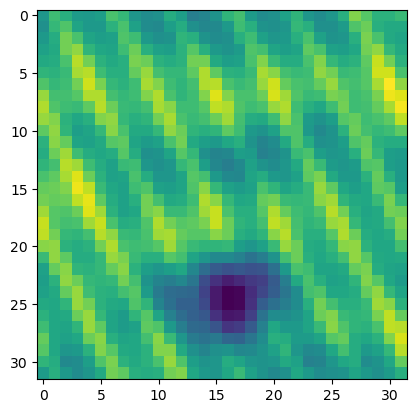

In [19]:

plt.imshow(img_list[22840,:,:])
plt.show()

In [20]:
net.forward(torch.from_numpy(img_list[22840,:,:].reshape(1,1,32,32)))

tensor([[1., 0.]], grad_fn=<SoftmaxBackward0>)

In [21]:
net.forward(torch.from_numpy(img_list[67,:,:].reshape(1,1,32,32)))

tensor([[1., 0.]], grad_fn=<SoftmaxBackward0>)